In [14]:
import pyvista as pv
import numpy as np
from typing import Any, Tuple
from importlib import reload
import multiprocessing
import ifcopenshell
import ifcopenshell.geom
import time
from functools import reduce
import open3d as o3d
import glob
import os
import pandas as pd

In [15]:
def open3d_block_by_element(ifc_file): 
    settings = ifcopenshell.geom.settings()
    settings.set(settings.USE_WORLD_COORDS, True)
    settings.set(settings.APPLY_DEFAULT_MATERIALS, True)
    iterator = ifcopenshell.geom.iterator(settings, ifc_file, multiprocessing.cpu_count())
    include_list = ["IfcWall", "IfcSlab", "IfcBeam", "IfcColumn", "IfcWallStandardCase", "IfcFoundation", "IfcRoof"]
    all_meshes = []
    element_information = {}
    ind = 0
    temp_dimension = 5.0
    if iterator.initialize():
        while True:
            shape = iterator.get()
            if shape.type in include_list:
                
                product = ifc_file.by_guid(shape.guid)

                faces = np.array(shape.geometry.faces)             
                verts = np.array(shape.geometry.verts).reshape(-1, 3)
                mesh = o3d.geometry.TriangleMesh()
                mesh.vertices = o3d.utility.Vector3dVector(verts)
                mesh.triangles = o3d.utility.Vector3iVector(faces.reshape(-1, 3))

                #find the smallest dimension of the mesh
                min_dimension = min(mesh.get_max_bound() - mesh.get_min_bound())
                if min_dimension > 0.1:
                    if temp_dimension > min_dimension:
                        temp_dimension = round(float(min_dimension),3)
                
                all_meshes.append(mesh)
         
                #attributes = product.get_info()
                element_information[ind] = shape.guid
                ind += 1
                        
            if not iterator.next():
                break
    

    return all_meshes, element_information, temp_dimension

def create_uniform_grid(bounds, voxel_size):
    """Create a uniform grid within the given bounds."""
    x = np.arange(bounds[0], bounds[1] + voxel_size, voxel_size)
    y = np.arange(bounds[2], bounds[3] + voxel_size, voxel_size)
    z = np.arange(bounds[4], bounds[5] + voxel_size, voxel_size)
    return pv.StructuredGrid(*np.meshgrid(x, y, z))

def open3d_to_pyvista(point_cloud_o3d):
    """
    Convert an Open3D point cloud to a PyVista point cloud.

    Parameters:
    - point_cloud_o3d: The Open3D point cloud.

    Returns:
    - A PyVista `PolyData` object.
    """
    # Extract points from Open3D point cloud
    points = np.asarray(point_cloud_o3d.points)

    # Create a PyVista PolyData object
    point_cloud_pv = pv.PolyData(points)

    return point_cloud_pv

def process_point(pcd, mesh_guid, grid_bounds, voxel_size, dims, grid_values, grid_attributes):
    j = int((pcd[0] - grid_bounds[0]) / voxel_size)
    i = int((pcd[1] - grid_bounds[2]) / voxel_size)
    k = int((pcd[2] - grid_bounds[4]) / voxel_size)
    
    if 0 <= i < dims[0]-1 and 0 <= j < dims[1]-1 and 0 <= k < dims[2]-1 and grid_values[i,j,k] == 0:
        grid_values[i,j,k] = 1
        grid_attributes[i,j,k] = mesh_guid

def voxelize_space(bounds, element_information, pcd_list, voxel_size):
    """Create a 3d grid and check the intersections of the meshes with the grid."""
    grid = create_uniform_grid(bounds, voxel_size)
    empty_grid = create_uniform_grid(bounds, voxel_size)
    
    # create an empty 3d array in the same dimensions of the grid
    dims = grid.dimensions
    grid_values = np.zeros((dims[0]-1, dims[1]-1, dims[2]-1))
    grid_attributes = np.empty((dims[0]-1, dims[1]-1, dims[2]-1), dtype=object)

    grid_bounds = grid.bounds

    [process_point(point, element_information[i], grid_bounds, voxel_size, dims, grid_values, grid_attributes) 
    for i, pcd in enumerate(pcd_list) for point in pcd.points]

    # assign empty array to the grid
    grid.cell_data['values'] = grid_values.flatten(order='F').astype(bool)
    grid.cell_data['attributes'] = grid_attributes.flatten(order='F').astype(str)
    
    return grid, empty_grid

def get_sampling_points(mesh, voxel_size, points_per_unit_area=120):
    
    # Calculate the surface area of the mesh
    area = mesh.get_surface_area()

    # Calculate the number of points to sample
    N = int(area * points_per_unit_area*1/voxel_size)
        
    return N

def create_point_cloud(all_meshes, voxel_size):
    """Create a point cloud from a mesh."""

    pcd_list = []
    
    for mesh in all_meshes:
        # Get the number of points to sample based on the mesh size
        N = get_sampling_points(mesh, voxel_size)
        pcd = mesh.sample_points_uniformly(N)
        pcd_pv = open3d_to_pyvista(pcd)
        pcd_list.append(pcd_pv)  
    
    return pcd_list


def fetch_concrete_elements(ifc_file, grid, voxel_size):
    elements = ifc_file.by_type("IfcBuildingElement")
    concrete_names = ["STB", "concrete", "beton"]
    
    concrete_elements = set()

    for element in elements:
        # Check ObjectType and Name attributes
        if any(concrete_name.lower() in (element.ObjectType or "").lower() for concrete_name in concrete_names) or \
           any(concrete_name.lower() in (element.Name or "").lower() for concrete_name in concrete_names):
            concrete_elements.add(element.GlobalId)
        else:
            # Check property sets
            for rel in element.IsDefinedBy:
                if rel.is_a("IfcRelDefinesByProperties"):
                    property_set = rel.RelatingPropertyDefinition
                    if property_set.is_a("IfcPropertySet"):
                        for prop in property_set.HasProperties:
                            if prop.is_a("IfcPropertySingleValue") and \
                               any(concrete_name.lower() in str(prop.NominalValue.wrappedValue).lower() for concrete_name in concrete_names):
                                concrete_elements.add(element.GlobalId)
                                break  # Exit once a match is found in the property set

    # Use NumPy's isin function to count all matching cells at once
    matching_cells = np.isin(grid.cell_data['attributes'], list(concrete_elements))
    total_count = np.sum(matching_cells)
    
    concrete_volume = round(total_count * voxel_size**3, 3)
    
    return concrete_volume


In [16]:
def process_ifc_file(file_name):
    ifc_file = ifcopenshell.open(file_name)
    print(file_name)

    ### CONVERSION FROM IFC TO MESH ###
    start_time = time.time()
    all_meshes, element_information, voxel_size = open3d_block_by_element(ifc_file)
    end_time = time.time()
    conversion_time = end_time - start_time
    total_polygons = sum(len(mesh.triangles) for mesh in all_meshes)

    # combine all meshes into one mesh and find the bounds
    combined_mesh = reduce(lambda m1, m2: m1 + m2, all_meshes)
    # Compute the oriented bounding box (OBB)
    obb = combined_mesh.get_oriented_bounding_box()

    # Extract the eight corner points of the OBB
    obb_points = np.asarray(obb.get_box_points())

    # Compute the axis-aligned bounding box of these eight points
    xmin, ymin, zmin = np.min(obb_points, axis=0)
    xmax, ymax, zmax = np.max(obb_points, axis=0)

    bounds = np.array([xmin, xmax, ymin, ymax, zmin, zmax])

    ### POINT CLOUD CREATION ###
    start_time = time.time()
    point_cloud_list  = create_point_cloud(all_meshes, voxel_size)

    #merge all the list of point clouds into one
    pcd_pv = pv.PolyData()
    pcd_pv.points = np.vstack(list(map(lambda x: x.points, point_cloud_list)))
    sampling_points = len(pcd_pv.points)
    end_time = time.time()
    point_cloud_processing = end_time - start_time

    ### RASTERIZATION ###
    start_time = time.time()
    grid, empty_grid = voxelize_space(bounds, element_information, point_cloud_list, voxel_size)
    end_time = time.time()
    rasterization_time = end_time - start_time

    ### VISUALIZATION ###
    start_time = time.time()
    p = pv.Plotter()
    p.add_mesh(pcd_pv, color="blue", point_size=10.0, render_points_as_spheres=True)
    p.add_mesh(empty_grid, opacity=0.3,show_edges=False)
    p.add_mesh(grid.extract_cells(grid.cell_data['values']), color="red", opacity=0.6,show_edges=False)
    screenshot_filename = os.path.join("screenshots", os.path.basename(file_name) + ".png")
    p.screenshot(screenshot_filename)
    p.show()
    end_time = time.time()
    visualization_time = end_time - start_time

    concrete_volume = fetch_concrete_elements(ifc_file, grid, voxel_size)
    print(f'Total concrete volume is {concrete_volume} m3')

    # Store the results in a dictionary
    results = {}
    results['File'] = file_name
    results['Conversion Time'] = conversion_time
    results['Total Polygons'] = total_polygons
    results['Voxel Size'] = voxel_size
    results['Total Points'] = sampling_points
    results['Point Cloud Creation Time'] = point_cloud_processing
    results['Rasterization Time'] = rasterization_time
    results['Visualization Time'] = visualization_time
    results['Concrete Volume'] = concrete_volume

    return results

c:\Users\Laptop\source\repos\ifc-voxelization
['01_Test.ifc', '02_Duplex.ifc', '03_Clinic.ifc']
['IFC Files\\01_Test.ifc', 'IFC Files\\02_Duplex.ifc', 'IFC Files\\03_Clinic.ifc']
IFC Files\01_Test.ifc


c:\Users\Laptop\AppData\Local\Programs\Python\Python310\lib\site-packages\pyvista\jupyter\notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


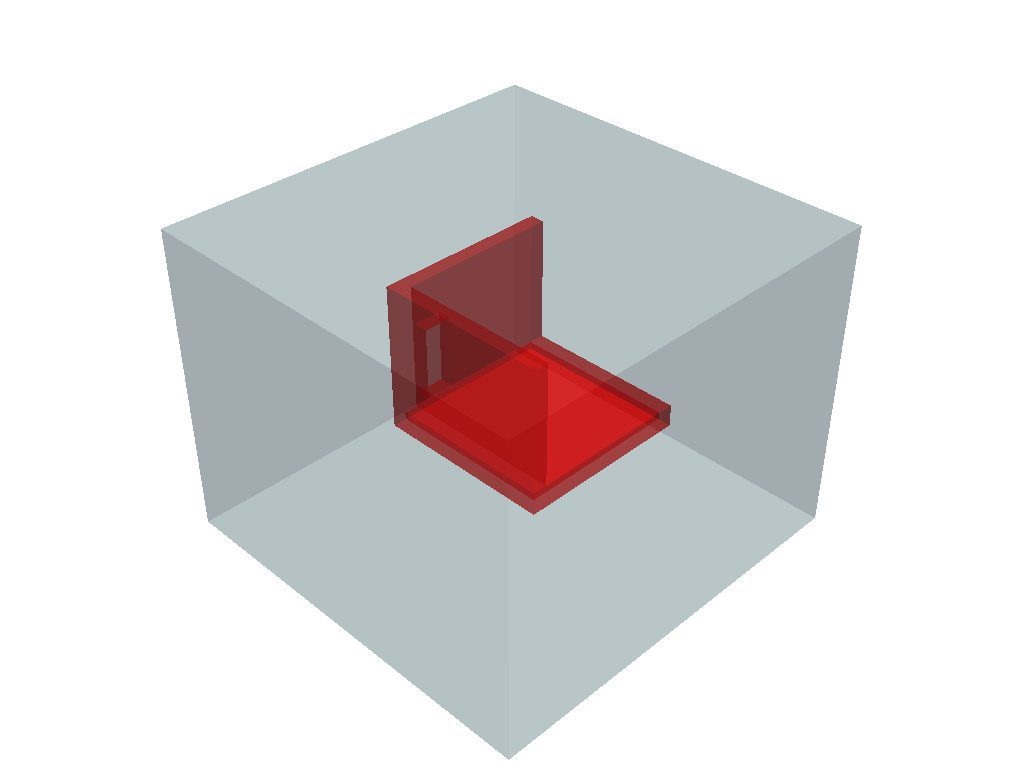

Total concrete volume is 9.952 m3
IFC Files\02_Duplex.ifc


c:\Users\Laptop\AppData\Local\Programs\Python\Python310\lib\site-packages\pyvista\jupyter\notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


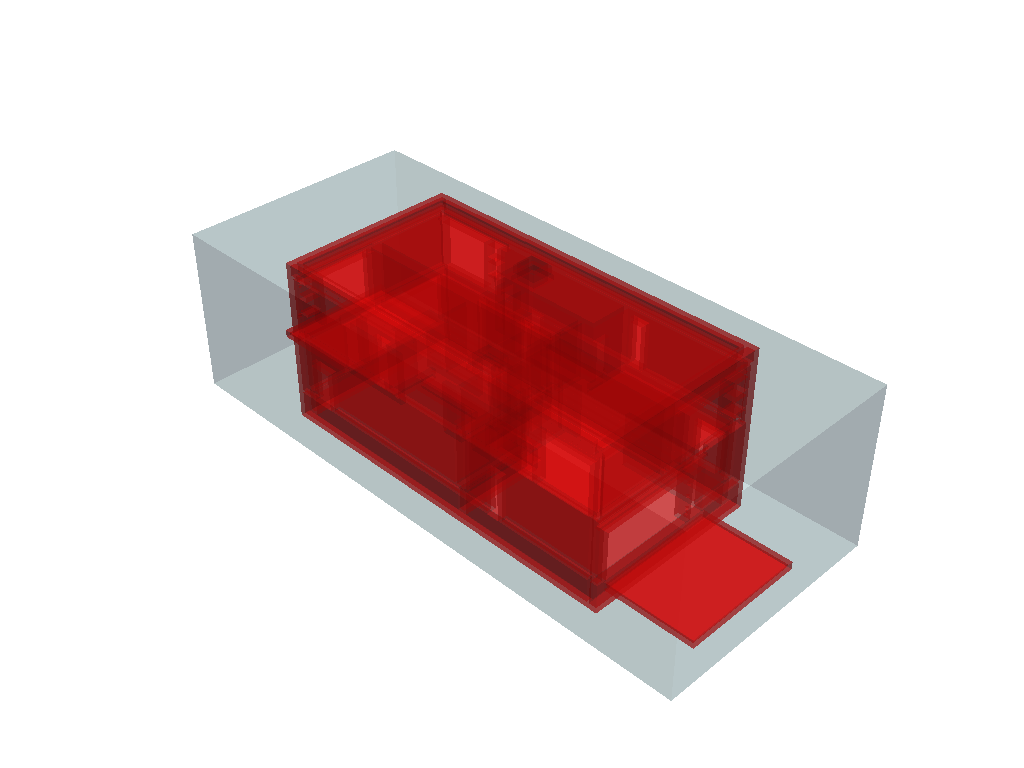

Total concrete volume is 23.941 m3
IFC Files\03_Clinic.ifc


c:\Users\Laptop\AppData\Local\Programs\Python\Python310\lib\site-packages\pyvista\jupyter\notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


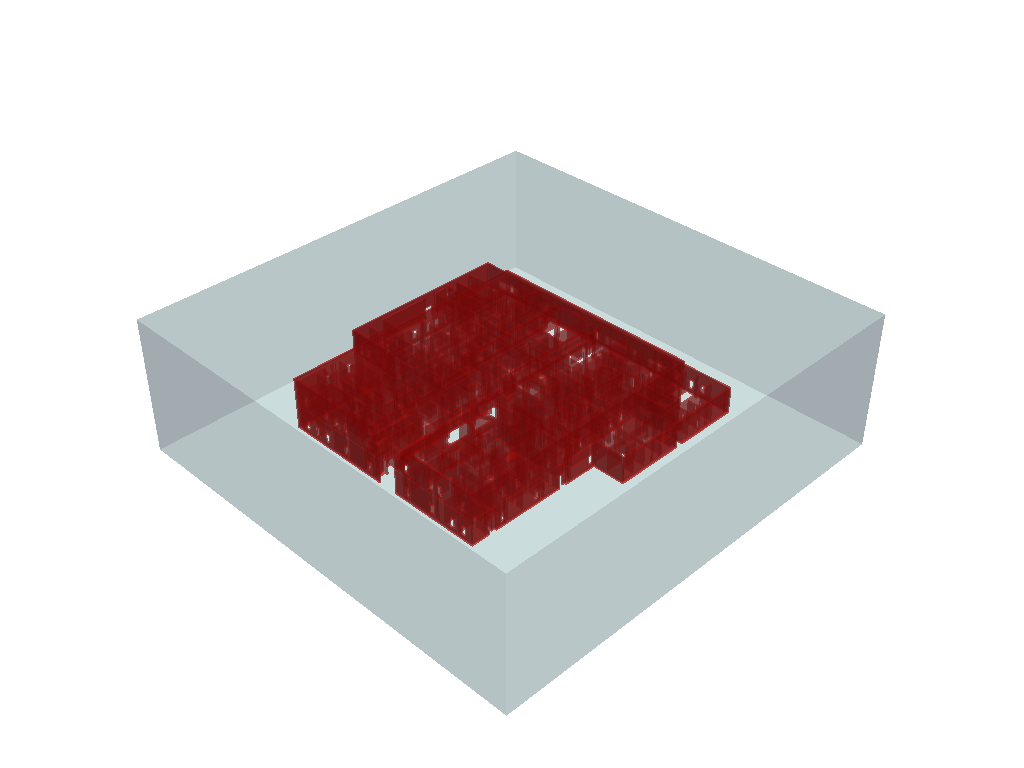

Total concrete volume is 1.07 m3


In [17]:
def find_ifc_files(directory):
    """Find all IFC files in a given directory."""
    # Use os.path.join to ensure the path is constructed correctly for any OS
    search_path = os.path.join(directory, "*.ifc")
    return glob.glob(search_path)

directory_path = "IFC Files/"

ifc_files = find_ifc_files(directory_path)

# Process each IFC file and store the results in a list
all_results = [process_ifc_file(file_name) for file_name in ifc_files]

# Convert the list of results to a DataFrame
df = pd.DataFrame(all_results)

# Write the DataFrame to an Excel file
df.to_excel("performance_results.xlsx", index=False)